# Initialization

## Import

In [1]:
import torch
import math
import torch.nn as nn
!pip install easydict

## Progress Bar

In [2]:
import sys
import time

TOTAL_BAR_LENGTH = 80
LAST_T = time.time()
BEGIN_T = LAST_T


def progress_bar(current, total, msg=None):
    global LAST_T, BEGIN_T
    if current == 0:
        BEGIN_T = time.time()  # Reset for new bar.

    current_len = int(TOTAL_BAR_LENGTH * (current + 1) / total)
    rest_len = int(TOTAL_BAR_LENGTH - current_len) - 1

    sys.stdout.write(' %d/%d' % (current + 1, total))
    sys.stdout.write(' [')
    for i in range(current_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    current_time = time.time()
    step_time = current_time - LAST_T
    LAST_T = current_time
    total_time = current_time - BEGIN_T

    time_used = '  Step: %s' % format_time(step_time)
    time_used += ' | Tot: %s' % format_time(total_time)
    if msg:
        time_used += ' | ' + msg

    msg = time_used
    sys.stdout.write(msg)

    if current < total - 1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()


# return the formatted time
def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    seconds_final = int(seconds)
    seconds = seconds - seconds_final
    millis = int(seconds*1000)

    output = ''
    time_index = 1
    if days > 0:
        output += str(days) + 'D'
        time_index += 1
    if hours > 0 and time_index <= 2:
        output += str(hours) + 'h'
        time_index += 1
    if minutes > 0 and time_index <= 2:
        output += str(minutes) + 'm'
        time_index += 1
    if seconds_final > 0 and time_index <= 2:
        output += str(seconds_final) + 's'
        time_index += 1
    if millis > 0 and time_index <= 2:
        output += str(millis) + 'ms'
        time_index += 1
    if output == '':
        output = '0ms'
    return output

## Data Loader

In [3]:
from os import listdir
from os.path import join

import torch.utils.data as data
from PIL import Image


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y


class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input_image = load_img(self.image_filenames[index])
        target = input_image.copy()
        if self.input_transform:
            input_image = self.input_transform(input_image)
        if self.target_transform:
            target = self.target_transform(target)

        return input_image, target

    def __len__(self):
        return len(self.image_filenames)

In [4]:
import os
import tarfile
from os import remove
from os.path import exists, join, basename

from six.moves import urllib
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

def download_bsd300(dest="/content/dataset"):
    output_image_dir = join(dest, "BSDS300/images")

    if not exists(output_image_dir):
        url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("downloading url ", url)

        os.makedirs(os.path.dirname(output_image_dir), exist_ok=True)

        data = urllib.request.urlopen(url)

        file_path = join(dest, basename(url))
        with open(file_path, 'wb') as f:
            f.write(data.read())

        print("Extracting data")
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)

        remove(file_path)

    return output_image_dir


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size // upscale_factor),
        ToTensor(),
    ])


def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(upscale_factor):
    root_dir = download_bsd300()
    train_dir = join(root_dir, "train")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(train_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))


def get_test_set(upscale_factor):
    root_dir = download_bsd300()
    test_dir = join(root_dir, "test")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(test_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

# Models

## FSRCNN Model

In [5]:
import torch
import torch.nn as nn


class FNet(torch.nn.Module):
    def __init__(self, num_channels, upscale_factor, d=64, s=12, m=4):
        super(FNet, self).__init__()

        self.first_part = nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=d, kernel_size=5, stride=1, padding=2),
                                        nn.PReLU())

        self.layers = []
        self.layers.append(nn.Sequential(nn.Conv2d(in_channels=d, out_channels=s, kernel_size=1, stride=1, padding=0),
                                         nn.PReLU()))
        for _ in range(m): # EXP
            self.layers.append(nn.Conv2d(in_channels=s, out_channels=s, kernel_size=3, stride=1, padding=1))
        self.layers.append(nn.PReLU())
        self.layers.append(nn.Sequential(nn.Conv2d(in_channels=s, out_channels=d, kernel_size=1, stride=1, padding=0),
                                         nn.PReLU()))
        self.mid_part = torch.nn.Sequential(*self.layers)
        # Deconvolution
        self.last_part = nn.ConvTranspose2d(in_channels=d, out_channels=num_channels, kernel_size=9, stride=upscale_factor, padding=int((10-upscale_factor)//2), output_padding=1)


    def forward(self, x):
        out = self.first_part(x)
        out = self.mid_part(out)
        out = self.last_part(out)
        return out

    def weight_init(self, mean=0.0, std=0.02):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.0001)
                if m.bias is not None:
                    m.bias.data.zero_()

In [6]:
!pip install progressbar2

# Trainer

## FSRCNN Solver

In [7]:
from __future__ import print_function
from math import log10

import torch
import torch.backends.cudnn as cudnn



class FSRCNNTrainer(object):
    def __init__(self, config, training_loader, testing_loader):
        super(FSRCNNTrainer, self).__init__()
        self.CUDA = torch.cuda.is_available()
        self.device = torch.device('cuda' if self.CUDA else 'cpu')
        self.model = None
        self.lr = config.lr
        self.nEpochs = config.nEpochs
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.seed = config.seed
        self.upscale_factor = config.upscale_factor
        self.training_loader = training_loader
        self.testing_loader = testing_loader
        self.dataForImage = []
        self.psnrForImage = []
        self.ssimForImage = []

    def build_model(self,n):
        self.model = FNet(num_channels=1, upscale_factor=self.upscale_factor,m = n).to(self.device)
        self.model.weight_init(mean=0.0, std=0.2)
        self.criterion = torch.nn.MSELoss()
        torch.manual_seed(self.seed)

        if self.CUDA:
            torch.cuda.manual_seed(self.seed)
            cudnn.benchmark = True
            self.criterion.cuda()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[50, 75, 100], gamma=0.5)  # lr decay

    def save_model(self):
        model_out_path = "model_path.pth"
        torch.save(self.model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

    def train(self):
        self.model.train()
        train_loss = 0
        for batch_num, (data, target) in enumerate(self.training_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(data), target)
            train_loss += loss.item()

            loss.backward()
            self.optimizer.step()
            progress_bar(batch_num, len(self.training_loader), 'Loss: %.4f' % (train_loss / (batch_num + 1)))

        print("    Average Loss: {:.4f}".format(train_loss / len(self.training_loader)))
        self.dataForImage.append(train_loss / len(self.training_loader))
    def train_data():
      return self.dataForImage, self.psnrForImage



    def test(self):
        self.model.eval()
        avg_psnr = 0
        avg_ssim = 0

        with torch.no_grad():
            for batch_num, (data, target) in enumerate(self.testing_loader):
                data, target = data.to(self.device), target.to(self.device)
                prediction = self.model(data)
                mse = self.criterion(prediction, target)
                ssim = calculate_ssim(target, prediction)
                psnr = 10 * log10(1 / mse.item())
                avg_psnr += psnr
                avg_ssim += ssim
                progress_bar(batch_num, len(self.testing_loader), 'PSNR: %.4f' % (avg_psnr / (batch_num + 1)))

        print("    Average PSNR: {:.4f} dB".format(avg_psnr / len(self.testing_loader)))
        self.psnrForImage.append(avg_psnr / len(self.testing_loader))
        self.ssimForImage.append(avg_ssim / len(self.testing_loader))

    def run(self, m):
        self.build_model(m)
        for epoch in range(1, self.nEpochs + 1):
            print("\n===> Epoch {} starts:".format(epoch))
            self.train()
            self.test()
            self.scheduler.step(epoch)
            if epoch == self.nEpochs:
                self.save_model()

## SSIM func

In [8]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(tensor1, tensor2):
    ssim_values = []
    for i in range(tensor1.size(0)):  # Iterate over the batch
        img1 = tensor1[i].cpu().detach().numpy().squeeze()  # Convert to numpy and remove channel dimension
        img2 = tensor2[i].cpu().detach().numpy().squeeze()  # Same for the second tensor

        # Calculate SSIM, assuming the images are grayscale so channel_axis is None
        ssim_value = ssim(img1, img2, data_range=img1.max() - img1.min())
        ssim_values.append(ssim_value)

    return np.mean(ssim_value)

# Runner

In [9]:
from __future__ import print_function

from torch.utils.data import DataLoader

import torch.nn.functional as F

class Config:
    def __init__(self):
        self.batchSize = 4
        self.testBatchSize = 1
        self.nEpochs = 1
        self.lr = 0.001
        self.seed = 123
        self.upscale_factor = 8


    def __str__(self):
        return '\n'.join(f'{k} = {v}' for k, v in self.__dict__.items())
    def changeConfig(self,batchSize,nEpochs,lr,upscale_factor):
        self.batchSize = batchSize
        self.nEpochs = nEpochs
        self.lr = lr
        self.upscale_factor = upscale_factor

config = Config()

def bicubic_method(train_data_loader, testing_data_loader, scale_factor):
    avg_train_psnr = 0.0
    avg_train_ssim = 0.0
    avg_train_loss = 0.0
    mse_loss_fn = torch.nn.MSELoss()
    for batch_num, (data, target) in enumerate(train_data_loader):
        bicubic_result = F.interpolate(data, scale_factor=scale_factor, mode='bicubic', align_corners=False)
        avg_train_psnr += psnr(target.cpu().detach().numpy(), bicubic_result.cpu().detach().numpy())
        avg_train_ssim += calculate_ssim(target, bicubic_result)
        avg_train_loss += mse_loss_fn(target, bicubic_result)
    avg_train_psnr /= (batch_num+1)
    avg_train_ssim /= (batch_num+1)
    avg_train_loss /= (batch_num+1)
    avg_test_psnr = 0.0
    avg_test_ssim = 0.0
    avg_test_loss = 0.0
    for batch_num, (data, target) in enumerate(testing_data_loader):
        bicubic_result = F.interpolate(data, scale_factor=scale_factor, mode='bicubic', align_corners=False)
        avg_test_psnr += psnr(target.cpu().detach().numpy(), bicubic_result.cpu().detach().numpy())
        avg_test_ssim += calculate_ssim(target, bicubic_result)
        avg_test_loss += mse_loss_fn(target, bicubic_result)
    avg_test_psnr /= (batch_num+1)
    avg_test_ssim /= (batch_num+1)
    avg_test_loss /= (batch_num+1)
    print(f'Bicubic Method Baseline: {avg_train_psnr=}, {avg_test_psnr=}, {avg_train_ssim=}, {avg_test_ssim}')

    return avg_test_loss, avg_test_psnr, avg_test_ssim



## Test for validaiton

## FSRCNN EXPERIMENT RUNNER

In [44]:
config.changeConfig(4, 100, 0.001, 4)#batchSize,nEpochs,lr,upscale_factor
M = [2,3,4,5,6]
def FSRCNNMain():
  allERROR = {}
  allPSNR = {}
  allSSIM = {}
  print('===> Loading datasets')
  train_set = get_training_set(config.upscale_factor)
  test_set = get_test_set(config.upscale_factor)
  training_data_loader = DataLoader(dataset=train_set, batch_size=config.batchSize, shuffle=True)
  testing_data_loader = DataLoader(dataset=test_set, batch_size=config.testBatchSize, shuffle=False)
  print('===> model base line')
  base_test_loss, base_test_psnr, base_test_ssim = bicubic_method(training_data_loader, testing_data_loader, config.upscale_factor)
  allERROR["Base Line"] = [base_test_loss for _ in range(config.nEpochs)]
  allPSNR["Base Line"] = [base_test_psnr for _ in range(config.nEpochs)]
  allSSIM["Base Line"] = [base_test_ssim for _ in range(config.nEpochs)]

  for n in M:
    print('===> model FSRCNN')
    print(f"For M = {n}")
    modelFSRCNN = FSRCNNTrainer(config, training_data_loader, testing_data_loader)
    modelFSRCNN.run(n)
    allERROR[str(n)] = (modelFSRCNN.dataForImage)
    allPSNR[str(n)] = (modelFSRCNN.psnrForImage)
    allSSIM[str(n)] = (modelFSRCNN.ssimForImage)

  return allERROR, allPSNR, allSSIM

In [ ]:
allERROR,allPSNR,allSSIM = FSRCNNMain()

===> Loading datasets
===> model base line
Bicubic Method Baseline: avg_train_psnr=23.203308087773767, avg_test_psnr=23.652214591248995, avg_train_ssim=0.6503407214976701, 0.6156241995974026
===> model FSRCNN
For M = 2

===> Epoch 1 starts:
 50/50 [================================================================================>]  Step: 164ms | Tot: 8s59ms | Loss: 0.0303
    Average Loss: 0.0303
 100/100 [================================================================================>]  Step: 38ms | Tot: 4s895ms | PSNR: 19.2246
    Average PSNR: 19.2246 dB

===> Epoch 2 starts:
 50/50 [================================================================================>]  Step: 162ms | Tot: 7s890ms | Loss: 0.0099
    Average Loss: 0.0099
 100/100 [================================================================================>]  Step: 33ms | Tot: 4s934ms | PSNR: 21.2223
    Average PSNR: 21.2223 dB

===> Epoch 3 starts:
 50/50 [============================================================

In [48]:
import matplotlib.pyplot as plt

def plotSSIM(ERROR, PSNR, SSIM, M, imgtitle="FSRCNN METRICS VS M"): # M = [2,3,4,5,6]
    x = M  # The list of M values to be used as x-axis points
    temperror = [ERROR[str(n)][-1] for n in M]
    temppsnr = [PSNR[str(n)][-1] for n in M]
    tempssim = [SSIM[str(n)][-1] for n in M]

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(3, 1, figsize=(6, 10))  # 3 rows, 1 column

    # Plot ERROR
    axs[0].plot(x, temperror, marker='o', linestyle='-', color='blue', label="ERROR")
    axs[0].set_title(imgtitle + ' - ERROR')
    axs[0].set_xlabel('M')
    axs[0].set_ylabel('ERROR')
    axs[0].legend()

    # Plot PSNR
    axs[1].plot(x, temppsnr, marker='o', linestyle='-', color='orange', label="PSNR")
    axs[1].set_title(imgtitle + ' - PSNR')
    axs[1].set_xlabel('M')
    axs[1].set_ylabel('PSNR')
    axs[1].legend()

    # Plot SSIM
    axs[2].plot(x, tempssim, marker='o', linestyle='-', color='green', label="SSIM")
    axs[2].set_title(imgtitle + ' - SSIM')
    axs[2].set_xlabel('M')
    axs[2].set_ylabel('SSIM')
    axs[2].legend()

    # Adjust layout so titles and labels don't overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

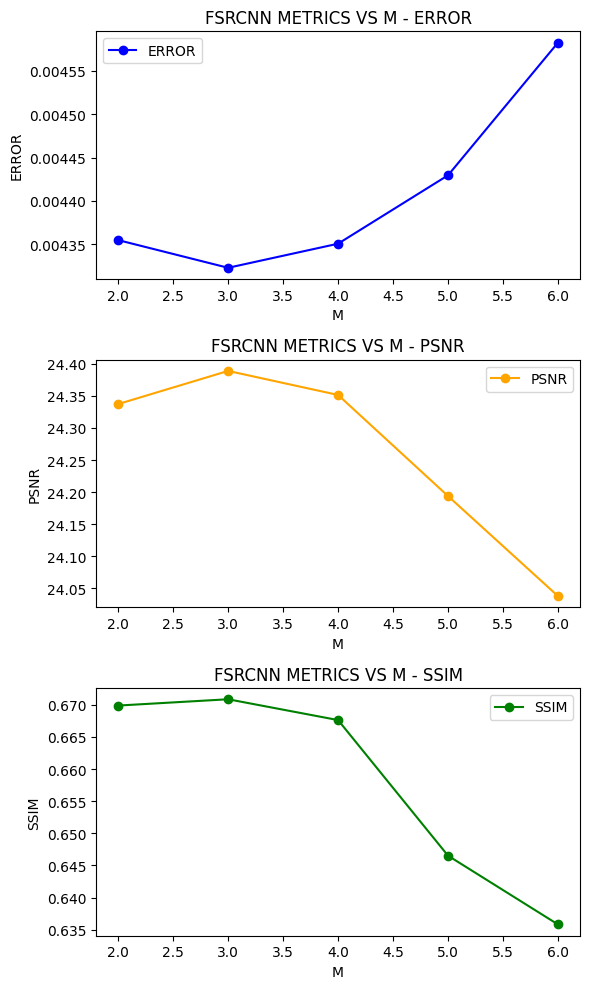

In [49]:
plotSSIM(allERROR, allPSNR, allSSIM, M, "FSRCNN METRICS VS M")